In [2]:
import datasource
import torch.utils.data
import sklearn.preprocessing
import numpy as np
from ray.air import session
from ray.train.torch import TorchCheckpoint, prepare_data_loader, prepare_model

def train_loop_per_worker(config):
    def _import_class(name:str):
        import importlib
        index = name.rfind('.')
        module_name = name[:index] if index != -1 else '__main__'
        class_name = name[index + 1:]
        return getattr(importlib.import_module(module_name), class_name)
    
    model = config['model']
    criterion = config['criterion']
    optimizer = config['optimizer']
    imputer = config['imputer']
    scaler = config['scaler']
    index_X = config['index_X']
    index_y = config['index_y']

    data = datasource.get_data()
    train_indexes, test_indexes = datasource.get_index_splited_by_time(data)

    concated_train_indexes = np.concatenate(train_indexes)
    if imputer:
        imputer = _import_class(imputer)(**config['imputer_args'])
        imputer.fit(data.loc[concated_train_indexes, [index_X, index_y]])
    if scaler:
        scaler_X = _import_class(scaler)()
        scaler_y = _import_class(scaler)()
        scaler_X.fit(data.loc[concated_train_indexes, index_X])
        scaler_y.fit(data.loc[concated_train_indexes, index_y])
        data.loc[:, index_X] = scaler_X.transform(data.loc[:, index_X])
        data.loc[:, index_y] = scaler_y.transform(data.loc[:, index_y])
    train_dataset = datasource.FSRDataset(data.loc[:, index_X], data.loc[:, index_y], train_indexes)
    test_dataset = datasource.FSRDataset(data.loc[:, index_X], data.loc[:, index_y], test_indexes)

    model = _import_class(model)(input_size=len(data.loc[:, index_X].columns), output_size=len(data.loc[:, index_y].columns), **config['model_args'])
    model = prepare_model(model)
    criterion = _import_class(criterion)()
    optimizer = _import_class(optimizer)(model.parameters(), **config['optimizer_args'])
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None)
    train_loader = prepare_data_loader(train_loader)
    test_loader = prepare_data_loader(test_loader)

    while True:
        model.train()
        for X, y in train_loader:
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.inference_mode():
            mae, mse, mape, num = [], [], [], []
            for X, y in test_loader:
                pred = model(X)
                if scaler:
                    pred = scaler_y.inverse_transform(pred)
                    y = scaler_y.inverse_transform(y)
                mae.append(sklearn.metrics.mean_absolute_error(y, pred))
                mse.append(sklearn.metrics.mean_squared_error(y, pred))
                mape.append(sklearn.metrics.mean_absolute_percentage_error(y, pred))
                num.append(len(y))
            mae = np.average(mae, weights=num)
            mse = np.average(mse, weights=num)
            mape = np.average(mape, weights=num)
            rmse = mse ** 0.5
        session.report(
            dict(rmse=rmse, mae=mae, mape=mape),
            checkpoint=TorchCheckpoint.from_dict(
                dict(model=model.state_dict(), optimizer=optimizer.state_dict()),
            ),
        ),

In [3]:
from ray.air.config import ScalingConfig, RunConfig, CheckpointConfig
from ray.air.integrations.wandb import WandbLoggerCallback
from ray.train.torch import TorchTrainer
from ray.tune.stopper import TrialPlateauStopper, ExperimentPlateauStopper, CombinedStopper, MaximumIterationStopper
from ray.data.preprocessors import Chain, SimpleImputer, MaxAbsScaler, MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker, 
    train_loop_config={
        'index_X':'FSR_for_force',
        'index_y':'force',
        'model':'fsr_model.LSTM',
        'model_args':{
            'hidden_size':8,
            'num_layer':1, 
        },
        'criterion':'torch.nn.MSELoss',
        'optimizer':'torch.optim.Adam',
        'optimizer_args':{
            'lr': 1e-3,
        },
        'imputer':'',
        'scaler':'sklearn.preprocessing.StandardScaler',
    },
    scaling_config=ScalingConfig(
        num_workers=2,
        use_gpu=False,
    ),
    run_config=RunConfig(
        stop=CombinedStopper(
            TrialPlateauStopper(metric='rmse'),
            ExperimentPlateauStopper(metric='rmse'),
        ),
        checkpoint_config=CheckpointConfig(
            num_to_keep=3,
            checkpoint_score_attribute='rmse',
            checkpoint_score_order='min',
        ),
    ),
)

In [4]:
def define_searchspace(trial):
    model = trial.suggest_categorical('model', ['fsr_model.LSTM', 'fsr_model.CNN_LSTM', 'fsr_model.ANN'])
    if model == 'fsr_model.LSTM':
        trial.suggest_categorical('model_args/hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_int('model_args/num_layer', 1, 8)
    elif model == 'fsr_model.CNN_LSTM':
        trial.suggest_categorical('model_args/cnn_hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_categorical('model_args/lstm_hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_int('model_args/cnn_num_layer', 1, 8)
        trial.suggest_int('model_args/lstm_num_layer', 1, 8)
    elif model == 'fsr_model.ANN':
        trial.suggest_categorical('model_args/hidden_size', [8, 16, 32, 64, 128])
        trial.suggest_int('model_args/num_layer', 1, 8)
    trial.suggest_categorical('criterion', ['torch.nn.MSELoss'])
    trial.suggest_categorical('optimizer', [
        'torch.optim.Adam',
        'torch.optim.NAdam',
        'torch.optim.Adagrad',
        'torch.optim.RAdam',
        'torch.optim.SGD',
    ])
    trial.suggest_float('optimizer_args/lr', 1e-5, 1e-1, log=True)
    imputer = trial.suggest_categorical('imputer', ['sklearn.impute.SimpleImputer'])
    if imputer == 'sklearn.impute.SimpleImputer':
        trial.suggest_categorical('imputer_args/strategy', [
            'mean',
            'median',
        ])
    trial.suggest_categorical('scaler', [
        'sklearn.preprocessing.StandardScaler',
        'sklearn.preprocessing.MinMaxScaler',
        'sklearn.preprocessing.RobustScaler',
    ])

In [9]:
import ray.train.xgboost
ray.train.xgboost.XGBoostTrainer()

ray.tune.trainable.util.with_parameters.<locals>._Inner

In [12]:
import ray.tune
import ray.air
import ray.air.integrations.wandb
import ray.tune.schedulers
import datasource
from trainable import Trainable
import ray.tune.search
import ray.tune.search.optuna

tuner = ray.tune.Tuner(
    trainable=Trainable,
    tune_config=ray.tune.TuneConfig(
        # scheduler=ray.tune.schedulers.ASHAScheduler(
        #     grace_period=1,
        #     reduction_factor=2,
        #     brackets=1,
        #     metric='rmse',
        #     mode='min',
        # ),
        search_alg=ray.tune.search.optuna.OptunaSearch(
            space=define_searchspace,
            metric='rmse',
            mode='min',
        ),
    ), 
    run_config=ray.air.RunConfig(
        # callbacks=[
        #     ray.air.integrations.wandb.WandbLoggerCallback(project='FSR-prediction'),
        # ],
    ),
)
results = tuner.fit()

[I 2023-07-04 18:28:41,016] A new study created in memory with name: optuna


2023-07-04 18:28:44,676	ERROR tune_controller.py:873 -- Trial task failed for trial Trainable_d6f07419
Traceback (most recent call last):
  File "/home/seokj/workspace/.venv/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/seokj/workspace/.venv/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 18, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/seokj/workspace/.venv/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/seokj/workspace/.venv/lib/python3.10/site-packages/ray/_private/worker.py", line 2542, in get
    raise value
ray.exceptions.RayActorError: The actor died because of an error raised in its creation task, ray::Trainable.__init__() (pid=1118631, ip=172.26.215.93, actor_id=f347eb1d4811a0c106a0725101000000, repr=<trainable.Trainable object at 0x7f7d36f7ff40>)
  File "

Trial name,trial_id
Trainable_d6f07419,d6f07419


2023-07-04 18:28:44,687	ERROR tune.py:1107 -- Trials did not complete: [Trainable_d6f07419]
2023-07-04 18:28:44,689	INFO tune.py:1111 -- Total run time: 3.67 seconds (3.65 seconds for the tuning loop).
2023-07-04 18:28:44,691	WARNING experiment_analysis.py:910 -- Failed to read the results for 1 trials:
- /home/seokj/ray_results/Trainable_2023-07-04_18-28-41/Trainable_d6f07419_1_criterion=torch_nn_MSELoss,imputer=sklearn_impute_SimpleImputer,strategy=mean,model=fsr_model_ANN,hidden_size_2023-07-04_18-28-41


(Trainable pid=1118631) 2023-07-04 18:28:44,669	ERROR worker.py:861 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::Trainable.__init__() (pid=1118631, ip=172.26.215.93, actor_id=f347eb1d4811a0c106a0725101000000, repr=<trainable.Trainable object at 0x7f7d36f7ff40>)
(Trainable pid=1118631)   File "/home/seokj/workspace/.venv/lib/python3.10/site-packages/ray/tune/trainable/trainable.py", line 170, in __init__
(Trainable pid=1118631)     self.setup(copy.deepcopy(self.config))
(Trainable pid=1118631) TypeError: Trainable.setup() missing 1 required positional argument: 'data'


In [60]:
checkpoint, metrics = result.best_checkpoints[-1]

In [98]:
from ray.train.torch import TorchPredictor
import fsr_model
predictor = TorchPredictor.from_checkpoint(checkpoint, model=fsr_model.LSTM(6, 8, 1, 6))
data = datasource.get_data()
_, test_indexes = datasource.get_index_splited_by_time(data)
X = data.loc[test_indexes[0], 'FSR_for_force'].to_numpy().astype(np.float32)
y = data.loc[test_indexes[0], 'force'].to_numpy().astype(np.float32)
tmp = np.random.random((10, 6)).astype(np.float32)
pred = predictor.predict(X)['predictions']

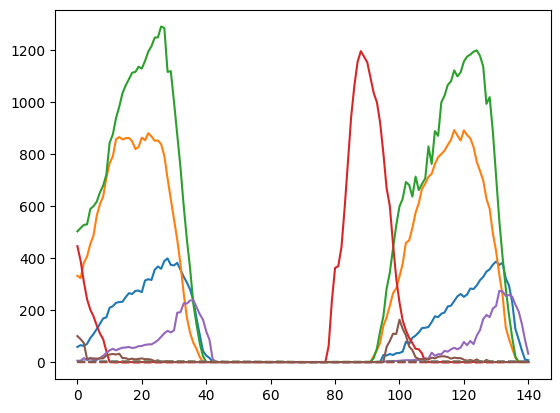

In [100]:
import matplotlib.pyplot as plt
ax = plt.subplot(111)
style = ax.plot(y, label=[1, 2, 3, 4, 5, 6])
for i in range(6):
    ax.plot(pred[:, i], color=style[i].get_color(), linestyle='--')